In [20]:
%matplotlib inline


# Creating and manipulating Datasets

**Gerd Duscher and Suhas Somnath**

08/25/2020

**This document is a simple example of how to create and manipulate Dataset
objects**

**UNDER CONSTRUCTION**


In [1]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals
import matplotlib.pylab as plt
import numpy as np
import sys

sys.path.append('../../')
import sidpy
print('sidpy version: ', sidpy.__version__)

sidpy version:  0.0.2


## Creating a ``sipy.Dataset`` object
We can create a simple sidpy Dataset from any array like object
Here we just use a numpy array filled with zeros



In [2]:
data_set = sidpy.Dataset.from_array(np.random.random([4, 5, 10]), name='random')
print(data_set)

sipy Dataset of type DataTypes.UNKNOWN with:
 dask.array<random, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
  a:  generic (generic) of size 4
  b:  generic (generic) of size 5
  c:  generic (generic) of size 10


Note that ``data_set`` is a dask array....
We will be improving upon the information that will be displayed when printing ``sidpy.Dataset`` objects

Accessing data within a ``Dataset``:
Indexing of the dataset works like in numpy
Note, that we first index and then we make a numpy array for printing reasons


In [3]:
print(np.array(data_set[:,0,2]))

[9.68676582e-05 6.14369943e-01 3.40107452e-01 3.76077974e-02]


Slicing and dicing:



## Metadata
``sidpy`` automatically assigns generic top-level metadata regarding the
``Dataset``. Users are encouraged to capture the context regarding the dataset.
The attributes included in the sidpy dataset are 
Required Attributes:

- ``quantity``: string: Physical quantity that is contained in this dataset

- ``units``: string: Units for this physical quantity

- ``data_type``: string : What kind of data this is. Example - image, image stack, video, hyperspectral image, etc.

- ``modality``: string : Experimental / simulation modality - scientific meaning of data. Example - photograph, TEM micrograph, SPM Force-Distance spectroscopy.

- ``source``: string : Source for dataset like the kind of instrument. One could go very deep here into either the algorithmic details if this is a result from analysis or the exact configurations for the instrument that generated this dataset.

Those attributes are set to ``generic`` originally but one would want to set them t
for the specific dataset. The attributes ``data_type``, ``quantity`` and ``units``  will be important for plotting the data.

Here's how one could do that, but with the wrong key word:



In [4]:
data_set.data_type = 'spectrum_image'  # not supported

Supported data_types for plotting are only:  ['UNKNOWN', 'SPECTRUM', 'LINE_PLOT', 'LINE_PLOT_FAMILY', 'IMAGE', 'IMAGE_MAP', 'IMAGE_STACK', 'SPECTRAL_IMAGE', 'IMAGE_4D']
Setting data_type to UNKNOWN


Here's how one could do that sucessfully:

In [5]:
data_set.data_type = 'spectral_image'  # supported

data_set.units = 'nA'
data_set.quantity = 'Current'

### Scientific metadata
These ``Dataset`` objects can also capture rich scientific metadata such as
acquisition parameters, etc. as well:
We would want to add those parameters as attributes.
These attributes could be lists, numpy arrays or simple dictionaries.
It is encouraged to add any parameters of data analysis to the datasets,
to keep track of input parameters. Here I made some up as an illustration:

 These ``Dataset`` objects can also capture rich scientific metadata such as acquisition parameters, etc. as well:

We would want to add those parameters as attributes. These attributes could be lists, numpy arrays or simple dictionaries. It is encouraged to add any parameters of data analysis to the datasets, to keep track of input parameters.

It is recommended to add any parameters to the (nested) metadata dictionary.
These metadata can then be viewed in dataset.view_metadata and dataset.view_original_metadata.
 Only in extreme cases should one resort to adding data as attributes (however these
 attributes will be stored in pyNSID)
Please note, that the dictionary ``original_metadata`` should not be changed so that information provided by the acquisition device stays pristine, but relevant inforamtion should be copied over to the ``metadaata`` attribute/dictionary.


Here I made some up metadata as an illustration:


In [6]:
data_set.calibration = np.arange(5)
data_set.metadata = {'nothing': ' ', 'value': 6.8, 'instrument': {'microscope': 'Nion', 'acceleration_voltage':60000}}
data_set.metadata['acquired'] = 'nowhere'

print(data_set.calibration)
sidpy.dict_utils.print_nested_dict(data_set.metadata)

[0 1 2 3 4]
nothing :  
value : 6.8
instrument :
	microscope : Nion
	acceleration_voltage : 60000
acquired : nowhere


Another set of metadata in these Datasets is the Dimension ones:



## Dimensions
The ``Dataset`` is automatically populated with generic information about
each dimension of the ``Dataset``. It is a good idea to capture context
regarding each of these dimensions using ``sidpy.Dimension``.
As a minimum we need a name and values (of the smae length as the dimensions of the data).
One can provide as much or as little information about each dimension.



In [7]:
data_set.set_dimension(0, sidpy.Dimension('x', np.arange(data_set.shape[0]),
                                        units='um', quantity='Length',
                                        dimension_type='spatial'))
data_set.set_dimension(1, sidpy.Dimension('y', np.linspace(-2, 2, num=data_set.shape[1], endpoint=True),
                                        units='um', quantity='Length',
                                        dimension_type='spatial'))
data_set.set_dimension(2, sidpy.Dimension('bias', np.sin(np.linspace(0, 2 * np.pi, num=data_set.shape[2])),
                                        ))

One could also manually add information regarding specific components of
dimensions associated with Datasets via:



In [8]:
data_set.bias.dimension_type = 'spectral'
data_set.bias.units = 'V'
data_set.bias.quantity = 'Bias'

Let's take a look at what the dataset looks like with the additional information
regarding the dimensions. 

We can access a dimensionby it's name or by the dimension number.

Also the print function provides now a little more information about our dataset.

In [10]:
print(data_set.bias)
print(data_set.dim_1)
print(data_set)

bias - Bias (V): [ 0.00000000e+00  6.42787610e-01  9.84807753e-01  8.66025404e-01
  3.42020143e-01 -3.42020143e-01 -8.66025404e-01 -9.84807753e-01
 -6.42787610e-01 -2.44929360e-16]
y - Length (um): [-2. -1.  0.  1.  2.]
sipy Dataset of type DataTypes.SPECTRAL_IMAGE with:
 dask.array<random, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: Current (nA)
 and Dimensions: 
  x:  Length (um) of size 4
  y:  Length (um) of size 5
  bias:  Bias (V) of size 10


## Plotting
The ``Dataset`` object also comes with the ability to visualize its contents
using the ``plot()`` function. Here we only show a simple application, but a more
detailed description can be found in the plotting section.
Here we plot a spectral image you can click in the image part of the plot on the
left and the spectrum on the right will update.



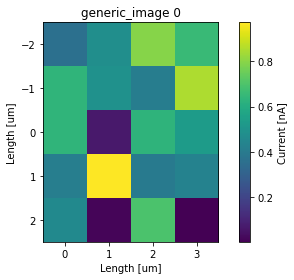

In [18]:
data_set.plot()

The plotting depends on the data_type of the dataset and the dimension_types
of it's dimension datasets. We set above the first two dimension_type types to
``spatial`` and the third one to ``spectral``.

The data_type was ``spectrum_image``.
So the spatial dimensions are recognized as relevant for an image.
If we change the data_type to image, we get an image.



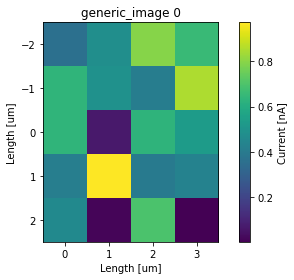

In [19]:
data_set.data_type = 'image'
data_set.plot()

## Saving

These ``Dataset`` objects will be deleted from memory once the python script
completes or when a notebook is closed. The information collected in a
``Dataset`` can reliably be stored to files using functions in sister
packages - ``pyUSID`` and ``pyNSID`` that write the dataset according to the
**Universal Spectroscopy and Imaging Data (USID)** or **N-dimensional
Spectrocsopy and Imaging Data (NSID)** formats.
Here are links to how one could save such Datasets for each package:

